In [1]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt

# Keller's model

> In his original 1974 paper, Keller proposed a model to determine "how a runner should vary his speed $v(t)$ during a race of distance $D$ in order to run it in the shortest time". 

$$D = \int_0^T v(t) dt$$

> The velocity satisfies the equation of motion:

$$\frac{dv}{dt} + \frac{v}{\tau} = f(t)$$

> $v/\tau$ is a resistive force per unit mass, $\tau$ is a given constant, $f(t)$ is the propulsive force per unit mass, controlled by the runner. Furthermore, $\forall t \ f(t)\leq F$, where $F$ is a maximum value.  

> The force affects the quantity $E(t)$ of available oxygen in the muscles per unit mass (oxygen is consumed in reactions which release the energy used in running). Energy is used at the rate $f v$, the oxygen is supplied at a rate $\sigma$. The oxygen balance equation is:

$$\frac{d E}{d t} = \sigma - f v$$

> Eventually, Keller found $v(t)$, $f(t)$ and $E(t)$ that minimized the total running time $T$. 

> Let's use this model in our optimization problem of the rat running on a treadmill. Let's work entirely in the frame of the laboratory. 

> Taking $f$ as the control parameter, the state can be written as:

$$x = \begin{pmatrix}
x_0(t)\\
x_1(t)
\end{pmatrix}=
\begin{pmatrix}
\textrm{position}\\
\textrm{velocity}
\end{pmatrix}$$

$$\dot{x} = \begin{pmatrix}
x_1(t)\\
u - \frac{(x_1(t)-v_t)}{\tau}
\end{pmatrix}=
\begin{pmatrix}
\textrm{velocity}\\
\textrm{acceleration}
\end{pmatrix}$$

> The cost that we will minimize is:

$$E(x(t),u(t))=\int_0^T \frac{d E}{d t}=\int_0^T \left[\sigma - u\left(x_1(t) - v_t\right)\right] dt$$

> We know (from paper ***) that $v_{max}=\tau \times F$, so the only unknown parameters are $\tau$ and $\sigma$. These can be estimated using values computed for human beings. The influence of these parameters on the optimal trajectories is discussed in the following sections.

$$0.0 \leq x_0(t) \leq L_{tread}$$
$$-0.6 \leq x_1(t) \leq 0.1$$ 

The rat should only run against the treadmill with an absolute velocity $|v_{max}|=0.7$ m/s.

$$-\frac{|v_{max}|}{\tau} \leq f(t) \leq \frac{|v_{max}|}{\tau}$$

In [2]:
def biomechanical_trajectory(tau_res,sigma,x0,xf,tf,option):
    '''This function takes tau and sigma from Keller's model as arguments, initial position x0
    and final position xf. It returns the optimized trajectory x0_opt, velocity x1_opt (and associated
    time array tgrid) and control u_opt (and associated time array tgrid_u)'''
    vtapis=0.1
    Ltread=0.9
    nk = 140   # Control discretization

    # Declare variables (use scalar graph)
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  vdp oscillator states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1], u -(x[1]-vtapis)/tau_res)
    rhs["L"] = sigma - u*(x[1]-vtapis)

    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -0.7/tau_res  #Fmax=vmax/tau
    u_max = -u_min
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess #in the frame of the laboratory!!
    x_min =  [0., -0.6, -inf]
    x_max =  [ Ltread, 0.1,  inf]
    xi_min = [x0,  vtapis,  0.0]
    xi_max = [x0,  vtapis,  0.0]
    xf_min = [xf,  0., -inf]
    xf_max = [xf,  0.,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
        # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

            # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]
    u_opt = opt["U",:,0]
    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    
    if option=='plot':
        return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u)
    elif option=='cost':
        return(float(res["f"]))

In [3]:
x0_opt,x1_opt,tgrid,u_opt,tgrid_u = biomechanical_trajectory(tau_res=0.05,sigma=8.107,x0=0.0,xf=0.0,tf=7.0,option='plot')


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equa

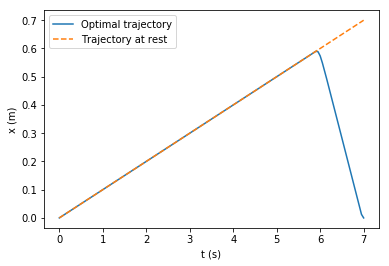

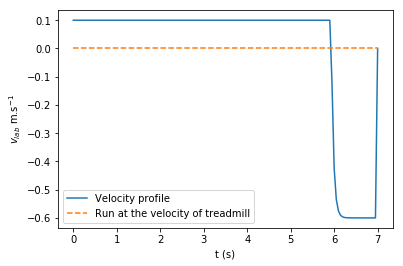

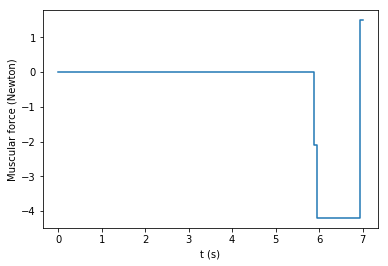

In [4]:
plt.plot(tgrid,x0_opt,label='Optimal trajectory')
plt.plot(tgrid,[0.1*t for t in tgrid],'--',label='Trajectory at rest')
plt.xlabel('t (s)')
plt.ylabel('x (m)')
plt.legend()
plt.show()

plt.plot(tgrid,x1_opt,label='Velocity profile')
plt.plot(tgrid,[0.0 for t in tgrid],'--',label='Run at the velocity of treadmill')
plt.ylabel(r'$v_{lab}$ m.s$^{-1}$')
plt.xlabel('t (s)')
plt.legend()
plt.show()

plt.step(tgrid_u,[f*0.3 for f in u_opt])
plt.ylabel('Muscular force (Newton)')
plt.xlabel('t (s)')
plt.show()

# Dependence on $\tau$

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

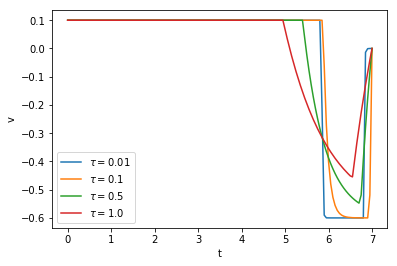

In [5]:
tauarray=[0.01,0.1,0.5,1.0]
for t in tauarray:
    x0_opt,x1_opt,tgrid,u_opt,tgrid_u = biomechanical_trajectory(tau_res=t,sigma=8.107,x0=0.0,xf=0.0,tf=7.0,option='plot')
    #plt.plot(tgrid,x0_opt,label='$\tau = $'+str(t))
    plt.plot(tgrid,x1_opt,label=r'$ \tau = $'+str(t))
plt.ylabel('v')
plt.xlabel('t')
plt.legend()
plt.show()


> Varying $\tau$ will not change the trajectory very much but changes can be observed in the velocity profile. An analysis of experimental velocity profiles should allow us to determine a good value for $\tau$. 

# Dependence on $\sigma$

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

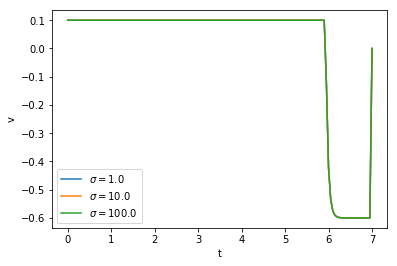

In [6]:
sigmarray=[1.0,10.0,100.0]
for s in sigmarray:
    x0_opt,x1_opt,tgrid,u_opt,tgrid_u = biomechanical_trajectory(tau_res=0.05,sigma=s,x0=0.0,xf=0.0,tf=7.0,option='plot')
    #plt.plot(tgrid,x0_opt,label=r'$\sigma = $'+str(s))
    plt.plot(tgrid,x1_opt,label=r'$ \sigma = $'+str(s))
plt.ylabel('v')
plt.xlabel('t')
plt.legend()
plt.show()


> Changing parameter $\sigma$ strongly affects the value of the final cost but has no influence on the trajectory and velocity profiles. 

# Adding a reward function

> Now that we have a model that can produce realistic trajectories minimizing the physical cost, we can try to implement a negative cost, a reward function that will make it advantageous for the rat to arrive at 7 seconds at the beginning of the treadmill. 

> If we evaluate the total physical cost for different durations, we will observe that the cost grows linearly with the duration of the experiment. If the rat minimizes its effort, it should go back to the beginning of the treadmill as early as possible. Obviously, in the experiment, a rat that goes to the origin too soon is penalised; it has to run more (we can see this as an additional energy cost). Arriving too soon means X additional Joules spent. Arriving at 7 seconds means that the rat gets a maximum reward, it is given some energy, hence the negative cost for durations larger than 7 seconds. The energy given, the reward, decreases in time: the negative cost must return to 0.0 as time passes. 

> Firstly we must compute the trajectories at fixed total duration for a set of durations. 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  31 3.4535080e+001 3.02e-004 2.35e+002  -5.7 5.39e-002  -8.4 1.00e+000 6.54e-001h  1
  32 3.4534025e+001 3.58e-005 2.77e+001  -5.7 1.96e-002  -8.9 1.00e+000 8.82e-001f  1
  33 3.4533890e+001 6.30e-009 1.21e-012  -5.7 2.59e-003  -9.3 1.00e+000 1.00e+000f  1
  34 3.4533246e+001 2.38e-007 6.08e+001  -8.6 2.37e-002  -9.8 9.99e-001 6.69e-001f  1
  35 3.4533083e+001 1.30e-007 2.89e+001  -8.6 8.16e-003 -10.3 1.00e+000 5.25e-001f  1
  36 3.4533001e+001 6.18e-008 1.27e+001  -8.6 3.95e-003 -10.8 1.00e+000 5.60e-001f  1
  37 3.4532966e+001 2.80e-008 5.59e+000  -8.6 1.77e-003 -11.2 1.00e+000 5.61e-001f  1
  38 3.4532950e+001 1.18e-008 2.32e+000  -8.6 7.94e-004 -11.7 1.00e+000 5.85e-001f  1
  39 3.4532942e+001 4.05e-009 7.84e-001  -8.6 3.36e-004 -12.2 1.00e+000 6.62e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.4532939e+001 5.30e-010 1.01e-001  -8.6 1.16e-004 -12.7 1.00e+000 8.71e-001f  1
  41 3.4532938e+001 2.71e-013 8.94e-015  -8.6 1.52e-005 -13

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  31 3.6576609e+001 2.23e-007 8.13e+001  -8.6 2.33e-002  -7.5 9.99e-001 5.58e-001f  1
  32 3.6576377e+001 1.35e-007 3.65e+001  -8.6 1.06e-002  -8.0 1.00e+000 5.52e-001f  1
  33 3.6576274e+001 6.71e-008 1.62e+001  -8.6 4.81e-003  -8.4 1.00e+000 5.57e-001f  1
  34 3.6576228e+001 3.11e-008 7.12e+000  -8.6 2.17e-003  -8.9 1.00e+000 5.60e-001f  1
  35 3.6576208e+001 1.36e-008 3.05e+000  -8.6 9.72e-004  -9.4 1.00e+000 5.71e-001f  1
  36 3.6576199e+001 5.47e-009 1.21e+000  -8.6 4.24e-004  -9.9 1.00e+000 6.04e-001f  1
  37 3.6576195e+001 1.58e-009 3.46e-001  -8.6 1.71e-004 -10.3 1.00e+000 7.14e-001f  1
  38 3.6576193e+001 2.58e-012 8.84e-015  -8.6 4.97e-005 -10.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  3.6576192914051674e+001   3.6576192914051674e+001
Dual infeasibility......:  8.8395738602113022e-015   8.8395738602113022e-015
Constraint violation....:  2.5839053119369737e-012   2.5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

Constraint violation....:  1.0896838986695911e-013   1.0896838986695911e-013
Complementarity.........:  3.1009068645007442e-009   3.1009068645007442e-009
Overall NLP error.......:  3.1009068645007442e-009   3.1009068645007442e-009


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 41
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 41
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPOPT (w/o function evaluations)   =      0.221
Total CPU secs in NLP function evaluations           =      0.004

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        41
       nlp_g        0.002      0.00301        41
  nlp_grad_f            0            0        42
  nl

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  32 4.2702480e+001 2.74e-007 8.12e+001  -8.6 2.22e-002  -7.1 9.99e-001 5.58e-001h  1
  33 4.2702243e+001 1.63e-007 3.60e+001  -8.6 9.98e-003  -7.5 1.00e+000 5.58e-001f  1
  34 4.2702138e+001 8.01e-008 1.59e+001  -8.6 4.47e-003  -8.0 1.00e+000 5.59e-001f  1
  35 4.2702093e+001 3.69e-008 6.99e+000  -8.6 2.00e-003  -8.5 1.00e+000 5.60e-001f  1
  36 4.2702072e+001 1.61e-008 2.98e+000  -8.6 8.89e-004  -9.0 1.00e+000 5.73e-001f  1
  37 4.2702063e+001 6.46e-009 1.18e+000  -8.6 3.84e-004  -9.4 1.00e+000 6.03e-001f  1
  38 4.2702059e+001 2.10e-009 3.82e-001  -8.6 1.54e-004  -9.9 1.00e+000 6.77e-001f  1
  39 4.2702058e+001 1.44e-010 2.57e-002  -8.6 5.05e-005 -10.4 1.00e+000 9.33e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 4.2702057e+001 1.08e-013 7.24e-015  -8.6 3.56e-006 -10.9 1.00e+000 1.00e+000f  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:  4.27020574869184

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  32 4.4743227e+001 2.54e-007 7.73e+001  -8.6 2.20e-002  -8.0 9.99e-001 5.79e-001f  1
  33 4.4743003e+001 1.52e-007 3.48e+001  -8.6 9.38e-003  -8.4 1.00e+000 5.51e-001f  1
  34 4.4742899e+001 7.34e-008 1.48e+001  -8.6 4.26e-003  -8.9 1.00e+000 5.74e-001f  1
  35 4.4742854e+001 3.20e-008 6.12e+000  -8.6 1.84e-003  -9.4 1.00e+000 5.88e-001f  1
  36 4.4742835e+001 1.28e-008 2.38e+000  -8.6 7.67e-004  -9.9 1.00e+000 6.11e-001f  1
  37 4.4742828e+001 4.50e-009 8.31e-001  -8.6 3.02e-004 -10.3 1.00e+000 6.51e-001f  1
  38 4.4742824e+001 1.10e-009 2.01e-001  -8.6 1.07e-004 -10.8 1.00e+000 7.58e-001f  1
  39 4.4742823e+001 1.05e-012 6.17e-015  -8.6 2.62e-005 -11.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:  4.4742823476214021e+001   4.4742823476214021e+001
Dual infeasibility......:  6.1678347943440430e-015   6.1678347943440430e-015
Constraint violation....:  1.0465517341629038e-012   1.0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  34 4.8142943e+001 3.77e-008 6.81e+000  -8.6 1.96e-003  -8.9 1.00e+000 5.78e-001f  1
  35 4.8142921e+001 1.51e-008 2.65e+000  -8.6 8.33e-004  -9.4 1.00e+000 6.11e-001f  1
  36 4.8142913e+001 5.23e-009 9.05e-001  -8.6 3.28e-004  -9.9 1.00e+000 6.59e-001f  1
  37 4.8142909e+001 1.24e-009 2.13e-001  -8.6 1.13e-004 -10.3 1.00e+000 7.65e-001f  1
  38 4.8142908e+001 1.18e-012 7.45e-015  -8.6 2.70e-005 -10.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  4.8142907965236297e+001   4.8142907965236297e+001
Dual infeasibility......:  7.4461144182275098e-015   7.4461144182275098e-015
Constraint violation....:  1.1817213874110166e-012   1.1817213874110166e-012
Complementarity.........:  4.2395692381605989e-009   4.2395692381605989e-009
Overall NLP error.......:  4.2395692381605989e-009   4.2395692381605989e-009


Number of objective function evaluations             = 39
Number of objective gra

  38 4.9502550e+001 5.99e-010 9.84e-002  -8.6 7.89e-005 -10.8 1.00e+000 8.45e-001f  1
  39 4.9502549e+001 3.01e-013 6.21e-015  -8.6 1.24e-005 -11.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:  4.9502549039394410e+001   4.9502549039394410e+001
Dual infeasibility......:  6.2062723281000949e-015   6.2062723281000949e-015
Constraint violation....:  3.0103697312711120e-013   3.0103697312711120e-013
Complementarity.........:  4.1831850241982436e-009   4.1831850241982436e-009
Overall NLP error.......:  4.1831850241982436e-009   4.1831850241982436e-009


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 40
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 40
Number of inequality constraint Jacobian evaluatio

  30 5.0863494e+001 2.30e-004 1.27e+002  -5.7 2.51e-002  -7.0 1.00e+000 7.63e-001f  1
  31 5.0862956e+001 6.79e-008 2.11e-010  -5.7 6.21e-003  -7.5 1.00e+000 1.00e+000f  1
  32 5.0862409e+001 2.81e-007 8.16e+001  -8.6 2.15e-002  -8.0 9.98e-001 5.55e-001f  1
  33 5.0862156e+001 1.73e-007 3.41e+001  -8.6 9.64e-003  -8.4 1.00e+000 5.84e-001f  1
  34 5.0862046e+001 7.74e-008 1.31e+001  -8.6 4.05e-003  -8.9 1.00e+000 6.15e-001f  1
  35 5.0862002e+001 2.95e-008 4.69e+000  -8.6 1.58e-003  -9.4 1.00e+000 6.43e-001f  1
  36 5.0861985e+001 9.87e-009 1.53e+000  -8.6 5.69e-004  -9.9 1.00e+000 6.74e-001f  1
  37 5.0861980e+001 2.63e-009 4.02e-001  -8.6 1.88e-004 -10.3 1.00e+000 7.37e-001f  1
  38 5.0861978e+001 7.98e-011 1.16e-002  -8.6 4.98e-005 -10.8 1.00e+000 9.71e-001f  1
  39 5.0861978e+001 9.07e-014 6.20e-015  -8.6 1.50e-006 -11.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:  5.086197771

optimal cost:  51.54161479845924
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg

Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 37
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 37
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 36
Total CPU secs in IPOPT (w/o function evaluations)   =      0.197
Total CPU secs in NLP function evaluations           =      0.004

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        37
       nlp_g            0     0.000496        37
  nlp_grad_f            0            0        38
  nlp_hess_l            0            0        36
   nlp_jac_g        0.004      0.00446        38
      solver        0.201        0.201         1
optimal cost:  52.900739148598646
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient


EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        45
       nlp_g        0.005      0.00291        45
  nlp_grad_f            0            0        46
  nlp_hess_l            0            0        44
   nlp_jac_g        0.002      0.00352        46
      solver        0.216        0.216         1
optimal cost:  54.25966977315763
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
T

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

      solver        0.234        0.235         1
optimal cost:  59.693592626182195
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  31 6.3237081e+001 1.29e-002 2.06e-002  -3.8 2.32e+000  -2.1 1.00e+000 1.00e+000h  1
  32 6.3135738e+001 4.05e-003 2.25e-002  -3.8 9.89e-001  -1.6 1.00e+000 8.08e-001h  1
  33 6.3114358e+001 3.72e-003 4.26e-001  -3.8 2.61e+000  -2.1 1.00e+000 8.16e-002f  1
  34 6.3071496e+001 3.59e-003 5.06e-001  -3.8 1.08e+001  -2.6 9.80e-001 9.01e-002f  1
  35 6.3023797e+001 2.89e-003 3.55e-001  -3.8 2.21e+000  -2.2 1.00e+000 3.89e-001h  1
  36 6.2992951e+001 1.55e-003 1.50e-002  -3.8 8.25e-001  -1.7 9.99e-001 9.59e-001h  1
  37 6.2929893e+001 1.36e-002 8.01e-002  -3.8 3.39e+000  -2.2 1.00e+000 6.92e-001f  1
  38 6.2945180e+001 6.17e-003 6.20e-002  -3.8 8.62e-001  -1.8 1.00e+000 5.93e-001h  1
  39 6.2933677e+001 2.54e-003 5.79e-003  -3.8 1.06e+000  -2.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 6.2923196e+001 4.43e-004 6.65e-003  -3.8 4.57e-001  -1.8 1.00e+000 1.00e+000h  1
  41 6.2904428e+001 1.14e-002 1.06e-002  -3.8 2.17e+000  -2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  29 6.5733512e+001 7.73e-003 1.34e-001  -3.8 1.97e+000  -2.0 1.00e+000 4.21e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 6.5551614e+001 1.63e-002 2.17e-001  -3.8 1.62e+001  -2.5 6.56e-001 1.40e-001f  1
  31 6.5473606e+001 1.38e-002 2.56e-001  -3.8 2.39e+000  -2.1 1.00e+000 1.98e-001h  1
  32 6.5372623e+001 1.41e-002 1.75e-001  -3.8 1.02e+001  -2.5 1.84e-001 7.95e-002f  1
  33 6.5286484e+001 1.06e-002 4.69e-001  -3.8 2.82e+000  -2.1 7.26e-001 2.48e-001h  1
  34 6.5236083e+001 1.93e-002 4.60e-001  -3.8 6.22e+001  -2.6 4.35e-002 3.53e-002h  1
  35 6.5189063e+001 1.49e-002 1.51e-001  -3.8 2.33e+000  -2.2 6.44e-001 2.50e-001h  1
  36 6.5142430e+001 3.77e-002 1.43e-001  -3.8 4.90e+001  -2.6 5.45e-002 6.87e-002f  1
  37 6.5099659e+001 2.90e-002 1.54e-001  -3.8 3.30e+000  -2.2 5.73e-001 2.43e-001f  1
  38 6.5048611e+001 4.01e-002 2.24e-001  -3.8 1.59e+001  -2.7 4.49e-001 1.76e-001h  1
  39 6.4991434e+001 1.75e-002 7.81e-002  -3.8 1.82e+000  -3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  31 6.7640311e+001 1.13e-002 1.46e-001  -3.8 3.95e+000  -2.1 1.32e-001 1.76e-001h  1
  32 6.7408589e+001 1.45e-002 1.43e-001  -3.8 1.79e+001  -2.5 1.76e-001 7.51e-002f  1
  33 6.7290463e+001 1.24e-002 1.18e-001  -3.8 4.58e+000  -2.1 1.24e-001 1.57e-001h  1
  34 6.7126851e+001 1.58e-002 1.18e-001  -3.8 2.08e+001  -2.6 1.64e-001 5.78e-002f  1
  35 6.7061631e+001 1.41e-002 1.04e-001  -3.8 5.24e+000  -2.2 9.56e-002 1.09e-001h  1
  36 6.6925681e+001 1.68e-002 1.14e-001  -3.8 2.47e+001  -2.6 2.96e-001 6.46e-002f  1
  37 6.6893155e+001 1.60e-002 1.11e-001  -3.8 4.17e+000  -2.2 1.17e-001 6.16e-002h  1
  38 6.6669642e+001 4.91e-002 2.64e-001  -3.8 1.40e+001  -2.7 1.00e+000 3.26e-001f  1
  39 6.6618706e+001 1.37e-002 6.12e-002  -3.8 6.00e-001  -3.2 1.00e+000 7.28e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 6.6573140e+001 4.21e-004 1.58e-003  -3.8 4.24e-001  -3.6 1.00e+000 1.00e+000h  1
  41 6.6572869e+001 2.85e-007 8.00e-007  -3.8 1.04e-002  -4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  34 6.8732426e+001 2.86e-002 2.61e-001  -3.8 1.08e+001  -2.6 1.00e+000 2.82e-001f  1
  35 6.8686245e+001 1.61e-002 1.24e-001  -3.8 3.48e-001  -3.1 1.00e+000 4.37e-001h  1
  36 6.8609113e+001 2.53e-004 2.43e-003  -3.8 3.03e-001  -3.5 1.00e+000 1.00e+000h  1
  37 6.8609514e+001 1.64e-006 2.40e-006  -3.8 2.43e-002  -4.0 1.00e+000 1.00e+000h  1
  38 6.8530598e+001 1.39e-002 8.56e+003  -5.7 2.76e+000  -4.5 2.37e-001 8.13e-001f  1
  39 6.8523852e+001 5.43e-003 1.09e+003  -5.7 4.30e-002  -5.0 1.00e+000 6.09e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 6.8520323e+001 1.16e-003 2.32e+002  -5.7 1.83e-002  -5.4 1.00e+000 7.87e-001h  1
  41 6.8519385e+001 3.61e-008 4.38e-009  -5.7 3.61e-003  -5.9 1.00e+000 1.00e+000f  1
  42 6.8518893e+001 3.23e-007 9.29e+001  -8.6 2.14e-002  -6.4 9.94e-001 4.90e-001f  1
  43 6.8518529e+001 2.61e-007 2.64e+001  -8.6 1.09e-002  -6.9 1.00e+000 7.19e-001f  1
  44 6.8518424e+001 8.19e-008 6.81e+000  -8.6 3.09e-003  -7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  25 7.2558440e+001 1.98e-002 3.37e-002  -3.8 2.72e+000  -1.9 1.00e+000 7.35e-001f  1
  26 7.2520295e+001 1.95e-002 1.32e-001  -3.8 1.00e+001  -2.4 9.60e-001 1.61e-002f  1
  27 7.2012337e+001 2.08e-002 3.49e-002  -3.8 2.96e+000  -2.0 7.34e-001 7.53e-001f  1
  28 7.1642643e+001 2.57e-002 7.97e-002  -3.8 1.42e+001  -2.4 7.47e-001 1.48e-001f  1
  29 7.1515106e+001 2.19e-002 1.56e-001  -3.8 2.75e+000  -2.0 8.67e-001 1.79e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 7.1250105e+001 2.79e-002 2.01e-001  -3.8 1.46e+001  -2.5 8.04e-001 1.27e-001f  1
  31 7.1190426e+001 2.50e-002 2.92e-001  -3.8 3.10e+000  -2.1 1.00e+000 1.07e-001h  1
  32 7.1010402e+001 2.75e-002 2.49e-001  -3.8 1.40e+001  -2.5 1.63e-001 1.38e-001h  1
  33 7.0982439e+001 2.57e-002 3.74e-001  -3.8 2.70e+000  -2.1 1.00e+000 6.73e-002h  1
  34 7.0758663e+001 4.75e-002 2.23e-001  -3.8 1.04e+001  -2.6 1.00e+000 4.11e-001h  1
  35 7.0728201e+001 2.90e-002 1.10e-001  -3.8 7.34e-001  -3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  31 7.3267340e+001 2.71e-002 2.69e-001  -3.8 3.08e+000  -2.1 1.00e+000 7.75e-002h  1
  32 7.3084186e+001 2.96e-002 2.28e-001  -3.8 1.49e+001  -2.5 2.27e-001 1.33e-001h  1
  33 7.3046860e+001 2.73e-002 3.57e-001  -3.8 3.07e+000  -2.1 1.00e+000 8.34e-002h  1
  34 7.2880334e+001 2.77e-002 2.57e-001  -3.8 9.97e+000  -2.6 1.00e+000 3.09e-001h  1
  35 7.2868142e+001 2.54e-002 1.59e+000  -3.8 5.61e+000  -3.1 2.36e-001 8.53e-002h  1
  36 7.2782392e+001 5.91e-004 4.33e+001  -3.8 4.44e-001  -3.5 1.25e-001 1.00e+000f  1
  37 7.2781206e+001 5.89e-004 3.18e+001  -3.8 1.38e+000  -4.0 9.85e-001 1.12e-001H  1
  38 7.2780841e+001 9.69e-006 1.39e-001  -3.8 5.35e-002  -4.5 8.92e-001 1.00e+000f  1
  39 7.2780716e+001 8.37e-008 5.91e-008  -3.8 5.54e-003  -5.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.2772357e+001 2.69e-004 2.00e+002  -5.7 4.55e-001  -5.4 6.41e-001 6.55e-001f  1
  41 7.2770336e+001 1.50e-004 2.45e+003  -5.7 1.33e-001  -5

  31 7.3794350e+001 1.29e-002 1.23e-001  -3.8 3.88e+000  -2.1 1.00e+000 3.57e-001h  1
  32 7.3712200e+001 1.60e-002 4.71e-001  -3.8 1.47e+001  -2.5 2.49e-001 7.80e-002h  1
  33 7.3701369e+001 1.54e-002 6.82e-001  -3.8 7.42e+000  -3.0 5.17e-002 4.01e-002h  1
  34 7.3687400e+001 1.50e-002 7.78e-001  -3.8 2.64e+001  -3.5 5.70e-002 2.67e-002h  1
  35 7.3674379e+001 1.03e-002 2.18e+000  -3.8 2.47e+000  -4.0 1.04e-001 3.11e-001h  1
  36 7.3657778e+001 1.16e-002 1.56e+000  -3.8 6.99e+000  -2.6 1.90e-001 2.46e-001f  1
  37 7.3627882e+001 2.75e-005 3.22e+001  -3.8 9.03e-002  -3.1 1.89e-001 1.00e+000h  1
  38 7.3624772e+001 2.54e-003 2.91e+001  -3.8 1.06e+001  -2.7 1.30e-001 8.53e-002f  1
  39 7.3623632e+001 8.98e-004 8.25e+000  -3.8 4.19e-001  -3.2 3.57e-001 7.75e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.3622082e+001 8.48e-004 3.08e+000  -3.8 7.74e-001  -3.6 1.00e+000 4.27e-001f  1
  41 7.3622007e+001 1.53e-006 1.75e-006  -3.8 2.28e-002  -4

  33 7.4479353e+001 1.46e-002 3.63e+000  -3.8 2.31e+000  -2.1 5.78e-002 8.14e-002h  1
  34 7.4477038e+001 1.40e-002 3.39e+000  -3.8 2.52e+000  -2.6 1.10e-001 4.02e-002f  1
  35 7.4469780e+001 1.18e-002 2.85e+000  -3.8 2.87e+000  -3.1 1.37e-001 1.60e-001f  1
  36 7.4450806e+001 7.31e-003 1.20e+000  -3.8 2.66e+000  -2.6 8.36e-002 3.80e-001f  1
  37 7.4471740e+001 2.98e-002 1.57e+001  -3.8 3.21e+000  -3.1 3.00e-001 9.67e-001f  1
  38 7.4462925e+001 2.50e-002 1.23e+001  -3.8 6.61e+000  -2.7 5.34e-002 4.08e-001f  1
  39 7.4458925e+001 1.60e-002 2.53e+000  -3.8 2.42e+000  -2.3 1.00e+000 6.60e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.4456230e+001 1.17e-002 9.20e+000  -3.8 1.08e+000  -2.7 1.00e+000 2.77e-001f  1
  41 7.4453861e+001 8.68e-003 2.00e+000  -3.8 4.50e-001  -3.2 4.84e-001 2.60e-001f  1
  42 7.4447799e+001 7.34e-003 6.54e-001  -3.8 1.83e+000  -3.7 6.10e-001 6.41e-001f  1
  43 7.4443757e+001 7.29e-006 6.95e-002  -3.8 4.70e-002  -4

  33 7.5274164e+001 8.27e-003 3.29e+000  -3.8 2.44e+000  -2.1 1.47e-001 4.51e-001f  1
  34 7.5262433e+001 8.31e-003 3.07e+000  -3.8 1.51e+001  -2.6 4.26e-002 1.81e-002h  1
  35 7.5242887e+001 2.96e-003 1.81e+000  -3.8 9.08e-001  -2.2 1.92e-001 6.49e-001f  1
  36 7.5240780e+001 2.76e-003 4.24e+000  -3.8 2.36e+000  -2.6 2.62e-001 6.98e-002h  1
  37 7.5231664e+001 2.36e-003 3.14e+000  -3.8 1.41e+000  -2.2 3.35e-001 4.22e-001f  1
  38 7.5215696e+001 8.28e-003 2.28e+000  -3.8 3.70e+000  -2.7 2.38e-001 4.57e-001h  1
  39 7.5212481e+001 7.23e-003 2.41e+000  -3.8 1.84e+000  -2.3 1.00e+000 1.30e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.5207919e+001 2.49e-003 1.04e+000  -3.8 7.80e-002  -2.7 1.00e+000 6.56e-001f  1
  41 7.5205567e+001 3.81e-006 2.19e-005  -3.8 3.50e-002  -3.2 1.00e+000 1.00e+000f  1
  42 7.5200793e+001 1.62e-005 9.58e+003  -5.7 2.07e-001  -3.7 9.86e-001 3.41e-001f  1
  43 7.5194886e+001 3.32e-005 2.47e+003  -5.7 1.28e-001  -2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  81 7.5887447e+001 9.32e-005 7.83e-003  -5.7 1.71e-001  -1.5 9.63e-001 1.00e+000f  1
  82 7.5885302e+001 1.37e-004 1.49e-001  -5.7 8.58e-001  -2.0 1.00e+000 1.58e-001h  1
  83 7.5882536e+001 1.79e-004 1.44e-001  -5.7 2.34e-001  -1.6 4.18e-001 1.00e+000f  1
  84 7.5881389e+001 1.90e-004 1.26e-001  -5.7 1.15e+000  -2.1 1.00e+000 7.52e-002h  1
  85 7.5879886e+001 5.12e-005 7.11e-002  -5.7 1.40e-001  -1.6 9.80e-001 8.37e-001f  1
  86 7.5873181e+001 1.66e-003 8.17e-002  -5.7 7.24e-001  -2.1 7.81e-001 1.00e+000f  1
  87 7.5867017e+001 3.12e-004 6.47e-003  -5.7 3.13e-001  -1.7 1.00e+000 1.00e+000h  1
  88 7.5866440e+001 3.08e-004 2.75e-001  -5.7 1.46e+000  -2.2 1.00e+000 2.51e-002h  1
  89 7.5863169e+001 3.48e-004 6.46e-003  -5.7 3.51e-001  -1.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 7.5855696e+001 2.12e-003 5.22e-002  -5.7 1.97e+000  -2.2 1.00e+000 4.11e-001h  1
  91 7.5855721e+001 2.05e-003 1.81e+000  -5.7 2.22e-001  -1

  33 7.6956687e+001 1.52e-002 8.61e-001  -3.8 2.44e+000  -2.1 6.97e-002 1.32e-001f  1
  34 7.6910420e+001 1.39e-002 7.40e-001  -3.8 1.40e+001  -2.6 5.09e-002 8.25e-002f  1
  35 7.6855145e+001 9.19e-003 1.38e+001  -3.8 3.03e+000  -2.2 7.19e-002 3.41e-001f  1
  36 7.6850228e+001 8.05e-003 1.27e+001  -3.8 2.81e+000  -2.6 1.43e-001 1.24e-001f  1
  37 7.6846439e+001 7.37e-003 1.17e+001  -3.8 5.42e-001  -2.2 2.59e-002 8.38e-002f  1
  38 7.6837328e+001 3.95e-003 6.38e+000  -3.8 1.66e+000  -2.7 2.13e-001 4.65e-001f  1
  39 7.6815577e+001 4.67e-003 3.25e+000  -3.8 1.81e+000  -2.3 2.37e-001 5.40e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.6800310e+001 2.80e-003 1.05e+000  -3.8 9.10e-001  -1.8 8.81e-001 6.19e-001f  1
  41 7.6785370e+001 1.85e-003 9.00e-001  -3.8 1.13e+000  -2.3 8.21e-001 6.63e-001f  1
  42 7.6775992e+001 5.61e-004 1.24e-002  -3.8 4.18e-001  -1.9 1.00e+000 9.93e-001f  1
  43 7.6771616e+001 8.75e-004 5.93e-001  -3.8 3.12e+000  -2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

 107 7.7310085e+001 5.63e-008 3.71e-003  -8.6 3.35e-003  -1.3 1.00e+000 7.22e-001f  1
 108 7.7310082e+001 6.26e-008 8.45e-003  -8.6 1.48e-002  -1.8 1.00e+000 1.45e-001f  1
 109 7.7310080e+001 4.48e-008 5.78e-003  -8.6 4.19e-003  -1.3 1.00e+000 4.23e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 7.7310074e+001 1.04e-007 8.16e-003  -8.6 1.91e-002  -1.8 1.00e+000 2.58e-001f  1
 111 7.7310070e+001 7.36e-008 3.87e-003  -8.6 5.45e-003  -1.4 4.50e-001 5.04e-001f  1
 112 7.7310066e+001 1.13e-007 8.00e-003  -8.6 2.75e-002  -1.9 6.86e-001 1.42e-001f  1
 113 7.7310059e+001 1.42e-007 4.63e-004  -8.6 6.81e-003  -1.4 1.00e+000 9.67e-001f  1
 114 7.7310055e+001 1.53e-007 5.26e-003  -8.6 3.60e-002  -1.9 1.00e+000 7.03e-002f  1
 115 7.7310053e+001 1.15e-007 6.03e-003  -8.6 7.89e-003  -1.5 7.51e-001 2.49e-001f  1
 116 7.7310043e+001 4.53e-007 6.12e-003  -8.6 4.74e-002  -2.0 3.68e-001 2.29e-001f  1
 117 7.7310030e+001 3.40e-007 1.16e-002  -8.6 9.74e-003  -1

  35 7.8512849e+001 7.17e-003 9.65e+000  -3.8 6.55e-001  -2.2 8.77e-002 3.97e-001f  1
  36 7.8508739e+001 6.76e-003 9.13e+000  -3.8 2.03e+000  -2.6 6.21e-002 5.65e-002f  1
  37 7.8483536e+001 1.35e-003 8.05e+000  -3.8 4.47e-001  -2.2 1.16e-001 8.00e-001f  1
  38 7.8471088e+001 2.52e-003 6.65e+000  -3.8 3.21e+000  -2.7 1.65e-001 2.41e-001f  1
  39 7.8464262e+001 2.69e-003 5.62e+000  -3.8 2.64e+000  -2.3 2.17e-001 1.57e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.8463611e+001 2.08e-004 4.05e+001  -3.8 2.57e-001  -1.8 1.67e-001 1.00e+000f  1
  41 7.8445334e+001 5.05e-003 2.91e+001  -3.8 4.12e+000  -2.3 1.31e-001 2.79e-001h  1
  42 7.8441626e+001 3.09e-003 4.25e+000  -3.8 1.06e+000  -1.9 1.00e+000 8.38e-001f  1
  43 7.8427832e+001 2.66e-004 9.35e-003  -3.8 2.71e-001  -1.5 1.00e+000 1.00e+000h  1
  44 7.8392646e+001 3.49e-003 6.35e-002  -3.8 1.29e+000  -1.9 7.17e-001 7.53e-001h  1
  45 7.8381508e+001 3.90e-003 5.52e-001  -3.8 1.79e+001  -2

 122 7.7948435e+001 6.27e-005 1.03e-003  -5.7 1.38e-001  -2.1 1.00e+000 1.00e+000h  1
 123 7.7948123e+001 1.73e-005 1.44e-003  -5.7 7.25e-002  -1.7 1.00e+000 1.00e+000h  1
 124 7.7946669e+001 4.67e-004 2.49e-003  -5.7 3.76e-001  -2.2 1.00e+000 1.00e+000h  1
 125 7.7945067e+001 8.90e-005 2.90e-003  -5.7 1.64e-001  -1.8 1.00e+000 1.00e+000h  1
 126 7.7942391e+001 4.34e-004 1.47e-001  -5.7 9.08e-001  -2.2 9.73e-001 3.73e-001h  1
 127 7.7942421e+001 3.26e-004 9.06e-001  -5.7 5.19e-002  -2.7 1.00e+000 2.50e-001f  3
 128 7.7941982e+001 6.80e-007 1.96e-005  -5.7 1.44e-002  -3.2 1.00e+000 1.00e+000h  1
 129 7.7941983e+001 3.19e-011 2.15e-008  -5.7 9.85e-005  -3.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 7.7941286e+001 7.11e-007 5.47e+001  -8.6 2.09e-002  -4.1 9.99e-001 7.03e-001f  1
 131 7.7941147e+001 3.98e-007 2.84e+001  -8.6 6.17e-003  -4.6 1.00e+000 4.81e-001h  1
 132 7.7941043e+001 1.38e-007 8.67e+000  -8.6 3.20e-003  -5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 7.8915339e+001 1.05e-004 7.38e+002  -5.7 1.70e-001  -1.7 3.76e-001 1.00e+000f  1
  71 7.8907599e+001 3.78e-003 7.11e+002  -5.7 2.88e+000  -2.2 3.64e-002 3.39e-001h  1
  72 7.8902411e+001 4.23e-004 5.93e+002  -5.7 3.36e-001  -1.8 1.67e-001 1.00e+000f  1
  73 7.8885435e+001 4.36e-003 5.87e+002  -5.7 5.22e+001  -2.2 8.91e-003 1.93e-002f  1
  74 7.8883314e+001 2.82e-003 4.61e+002  -5.7 4.85e-001  -1.8 2.16e-001 3.56e-001f  1
  75 7.8873867e+001 3.13e-003 4.33e+002  -5.7 8.75e+000  -2.3 6.06e-002 7.02e-002f  1
  76 7.8873068e+001 2.92e-003 9.51e+001  -5.7 6.78e-001  -1.9 7.80e-001 6.83e-002f  1
  77 7.8871623e+001 2.89e-003 8.89e+001  -5.7 4.81e+000  -2.3 6.58e-002 2.23e-002h  1
  78 7.8870718e+001 2.54e-003 7.33e+001  -5.7 1.96e-001  -1.9 1.76e-001 1.21e-001f  1
  79 7.8868982e+001 2.06e-003 7.19e+001  -5.7 6.69e-001  -2.4 1.85e-002 2.11e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  33 8.0273722e+001 1.41e-002 3.48e+000  -3.8 3.81e+000  -2.1 8.26e-002 7.94e-002f  1
  34 8.0228297e+001 1.37e-002 3.37e+000  -3.8 2.41e+001  -2.6 2.14e-002 3.28e-002f  1
  35 8.0194762e+001 1.09e-002 6.36e+000  -3.8 2.87e+000  -2.2 4.72e-002 2.05e-001f  1
  36 8.0156982e+001 1.05e-002 6.89e+000  -3.8 2.61e+001  -2.6 2.30e-003 3.02e-002f  1
  37 8.0134860e+001 9.39e-003 5.49e+000  -3.8 4.09e+000  -2.2 8.31e-002 1.09e-001f  1
  38 8.0119656e+001 8.43e-003 4.95e+000  -3.8 6.51e+000  -2.7 6.94e-002 1.03e-001f  1
  39 8.0107609e+001 7.65e-003 4.49e+000  -3.8 2.47e+000  -2.3 2.20e-001 9.25e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 8.0097388e+001 6.45e-003 4.58e+000  -3.8 6.52e-001  -1.8 7.52e-001 1.56e-001h  1
  41 8.0065031e+001 4.00e-003 2.02e+000  -3.8 1.69e+000  -2.3 3.28e-001 4.57e-001f  1
  42 8.0029633e+001 2.82e-003 7.27e-001  -3.8 9.32e-001  -1.9 3.60e-001 7.34e-001f  1
  43 8.0023861e+001 1.35e-003 2.23e-002  -3.8 6.45e-001  -1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 8.0166048e+001 1.26e-003 6.98e-001  -5.7 1.01e+000  -1.8 1.00e+000 3.82e-001f  1
 111 8.0164154e+001 4.39e-004 9.64e-001  -5.7 1.08e-001  -2.3 1.00e+000 6.61e-001f  1
 112 8.0161963e+001 1.21e-005 1.33e-001  -5.7 6.54e-002  -1.9 8.44e-001 1.00e+000h  1
 113 8.0161645e+001 1.49e-004 1.50e-002  -5.7 2.28e-001  -2.3 9.80e-001 1.00e+000h  1
 114 8.0161338e+001 3.46e-005 1.31e-003  -5.7 1.10e-001  -1.9 1.00e+000 1.00e+000h  1
 115 8.0159350e+001 2.13e-003 3.42e-003  -5.7 8.61e-001  -2.4 1.00e+000 1.00e+000h  1
 116 8.0155284e+001 4.96e-004 4.40e-003  -5.7 4.15e-001  -2.0 1.00e+000 1.00e+000h  1
 117 8.0124816e+001 4.33e-002 1.36e-002  -5.7 3.88e+000  -2.5 1.00e+000 1.00e+000h  1
 118 8.0054947e+001 6.88e-003 1.43e-002  -5.7 1.54e+000  -2.0 1.00e+000 1.00e+000h  1
 119 8.0053768e+001 6.85e-003 7.10e-002  -5.7 9.17e+000  -2.5 1.00e+000 4.07e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  71 8.1113459e+001 1.02e-005 9.78e-003  -5.7 4.18e-002  -1.3 1.00e+000 6.28e-001f  1
  72 8.1111659e+001 1.64e-005 6.14e-002  -5.7 1.80e-001  -1.8 1.00e+000 2.52e-001f  1
  73 8.1110430e+001 1.09e-005 3.98e-002  -5.7 5.18e-002  -1.3 1.00e+000 5.07e-001f  1
  74 8.1108491e+001 1.96e-005 1.21e-001  -5.7 2.49e-001  -1.8 1.00e+000 2.16e-001f  1
  75 8.1107275e+001 1.43e-005 7.50e-002  -5.7 6.87e-002  -1.4 9.90e-001 4.24e-001f  1
  76 8.1104990e+001 2.80e-005 1.69e-001  -5.7 3.38e-001  -1.9 1.00e+000 1.96e-001f  1
  77 8.1103602e+001 2.11e-005 1.03e-001  -5.7 9.23e-002  -1.4 4.52e-001 3.91e-001f  1
  78 8.1101192e+001 3.73e-005 2.34e-001  -5.7 4.88e-001  -1.9 9.95e-001 1.49e-001f  1
  79 8.1099610e+001 2.93e-005 1.35e-001  -5.7 1.16e-001  -1.5 1.00e+000 3.61e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 8.1096322e+001 6.48e-005 2.11e-001  -5.7 6.61e-001  -2.0 5.73e-001 1.48e-001f  1
  81 8.1094224e+001 5.11e-005 1.58e-001  -5.7 1.48e-001  -1

  35 8.2670891e+001 1.94e-002 1.65e+000  -3.8 4.07e+000  -2.2 4.38e-002 3.10e-002f  1
  36 8.2599838e+001 1.76e-002 1.50e+000  -3.8 1.61e+001  -2.6 4.07e-002 9.59e-002f  1
  37 8.2571669e+001 1.56e-002 3.29e+000  -3.8 3.58e+000  -2.2 4.52e-002 1.12e-001f  1
  38 8.2559159e+001 1.42e-002 3.74e+000  -3.8 1.06e+000  -1.8 5.13e-001 9.00e-002f  1
  39 8.2543432e+001 1.20e-002 2.85e+000  -3.8 9.25e-001  -2.3 1.27e-001 1.52e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 8.2488301e+001 1.16e-003 1.09e+001  -3.8 3.11e-001  -1.8 1.96e-001 9.04e-001f  1
  41 8.2472758e+001 1.59e-003 5.73e+000  -3.8 1.36e+000  -2.3 2.23e-001 4.65e-001f  1
  42 8.2448879e+001 1.84e-003 2.76e+000  -3.8 9.37e-001  -1.9 3.54e-001 6.41e-001f  1
  43 8.2428673e+001 6.63e-004 7.98e-001  -3.8 4.08e-001  -1.5 5.48e-001 1.00e+000f  1
  44 8.2406412e+001 1.05e-003 6.68e-001  -3.8 1.53e+000  -1.9 5.95e-001 2.34e-001h  1
  45 8.2393535e+001 5.13e-004 1.64e+001  -3.8 4.04e-001  -1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

 108 8.2608039e+001 6.67e-004 1.18e+000  -5.7 5.08e-001  -1.8 2.20e-001 2.33e-001f  1
 109 8.2600398e+001 1.16e-003 1.04e+000  -5.7 2.57e+001  -2.2 3.78e-003 1.52e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 8.2592037e+001 1.09e-003 2.49e+000  -5.7 8.38e-001  -1.8 2.16e-001 4.41e-001f  1
 111 8.2581073e+001 2.50e-004 1.09e-002  -5.7 2.71e-001  -1.4 1.00e+000 1.00e+000f  1
 112 8.2575731e+001 3.12e-004 4.88e-002  -5.7 1.18e+000  -1.9 1.51e-001 1.35e-001h  1
 113 8.2573227e+001 1.74e-004 9.25e-001  -5.7 3.38e-001  -1.4 1.00e+000 5.18e-001f  1
 114 8.2564280e+001 7.17e-004 5.96e-001  -5.7 1.33e+000  -1.9 9.91e-002 3.09e-001h  1
 115 8.2564289e+001 7.12e-004 7.10e+000  -5.7 2.88e-001  -1.5 1.19e-001 7.81e-003f  8
 116 8.2561074e+001 7.46e-004 3.19e+000  -5.7 1.95e+000  -2.0 5.25e-001 8.33e-002h  1
 117 8.2558744e+001 3.02e-004 2.93e+000  -5.7 1.88e-001  -1.5 1.00e+000 6.00e-001f  1
 118 8.2550621e+001 6.01e-004 1.59e+000  -5.7 7.43e-001  -2

  33 8.4236478e+001 1.84e-002 1.21e+000  -3.8 3.88e+000  -2.1 4.99e-002 7.80e-002f  1
  34 8.4226393e+001 1.79e-002 2.22e+000  -3.8 1.68e+001  -2.6 8.86e-002 2.60e-002h  1
  35 8.4207131e+001 1.52e-002 1.39e+000  -3.8 1.02e+000  -2.2 1.01e-001 1.51e-001f  1
  36 8.4126289e+001 4.09e-004 1.23e+001  -3.8 3.23e-001  -1.7 1.14e-001 9.91e-001f  1
  37 8.4116118e+001 5.75e-004 8.67e+000  -3.8 1.31e+000  -2.2 1.47e-001 2.88e-001f  1
  38 8.4102884e+001 8.61e-004 3.25e+000  -3.8 6.58e-001  -1.8 6.41e-001 6.25e-001f  1
  39 8.4091980e+001 1.27e-003 2.97e+000  -3.8 4.84e+000  -2.3 1.09e-001 7.91e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 8.4071939e+001 2.07e-003 3.32e+001  -3.8 7.05e-001  -1.8 2.02e-001 9.98e-001f  1
  41 8.4047957e+001 3.73e-004 1.23e+000  -3.8 3.07e-001  -1.4 4.98e-001 1.00e+000f  1
  42 8.4010910e+001 1.78e-003 7.97e-001  -3.8 1.60e+000  -1.9 5.66e-001 3.92e-001h  1
  43 8.3986829e+001 8.39e-004 1.35e-001  -3.8 4.36e-001  -1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

 104 8.4030456e+001 3.22e-004 2.80e+000  -5.7 3.55e-001  -1.7 1.00e+000 1.15e-001h  1
 105 8.4027386e+001 1.92e-004 1.01e+000  -5.7 1.10e-001  -1.2 1.00e+000 4.11e-001f  1
 106 8.4024343e+001 1.67e-004 8.15e-001  -5.7 3.93e-001  -1.7 1.00e+000 1.82e-001f  1
 107 8.4022069e+001 1.09e-004 7.52e-001  -5.7 1.25e-001  -1.3 7.69e-001 3.67e-001f  1
 108 8.4018789e+001 1.03e-004 5.74e-001  -5.7 4.69e-001  -1.8 5.98e-001 1.78e-001f  1
 109 8.4016648e+001 7.15e-005 4.52e-001  -5.7 1.46e-001  -1.3 4.42e-001 3.47e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 8.4011851e+001 1.23e-004 3.46e-001  -5.7 5.57e-001  -1.8 2.47e-001 2.36e-001f  1
 111 8.4008720e+001 8.99e-005 1.40e-001  -5.7 1.70e-001  -1.4 2.61e-001 4.80e-001f  1
 112 8.4002591e+001 1.88e-004 1.19e-001  -5.7 7.60e-001  -1.9 2.65e-002 2.57e-001f  1
 113 8.4001820e+001 1.70e-004 1.62e+000  -5.7 2.24e-001  -1.4 1.00e+000 1.04e-001f  1
 114 8.3997715e+001 1.96e-004 4.97e-001  -5.7 8.97e-001  -1

  31 8.5984050e+001 1.64e-002 2.79e+000  -3.8 3.72e+000  -2.1 1.80e-001 1.48e-001f  1
  32 8.5975722e+001 1.63e-002 2.78e+000  -3.8 2.42e+001  -2.5 2.44e-002 5.26e-003f  1
  33 8.5944980e+001 1.55e-002 1.30e+001  -3.8 1.14e+001  -2.1 6.93e-003 4.88e-002f  1
  34 8.5891235e+001 9.98e-003 4.67e+000  -3.8 1.64e+000  -1.7 2.77e-002 3.58e-001f  1
  35 8.5879819e+001 9.72e-003 4.42e+000  -3.8 5.31e+000  -2.2 4.32e-001 2.68e-002h  1
  36 8.5774796e+001 3.63e-003 3.02e+000  -3.8 1.08e+000  -1.7 4.03e-001 1.00e+000f  1
  37 8.5767460e+001 3.60e-003 6.77e+000  -3.8 5.51e+000  -2.2 2.17e-001 2.21e-002h  1
  38 8.5717318e+001 3.77e-003 3.47e+000  -3.8 1.61e+000  -1.8 1.00e+000 4.87e-001f  1
  39 8.5694588e+001 5.26e-003 2.78e+000  -3.8 1.40e+001  -2.3 4.27e-002 7.93e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 8.5687714e+001 4.79e-003 2.59e+000  -3.8 1.05e+000  -1.8 7.08e-001 9.40e-002f  1
  41 8.5654176e+001 9.56e-004 4.06e-001  -3.8 2.76e-001  -1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:     1827
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1264
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1680
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

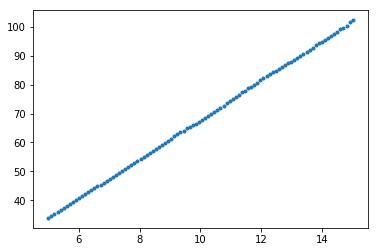

In [7]:
tarray=np.linspace(5,15,100)
cost=[]
for t in tarray:
    cost.append(biomechanical_trajectory(tau_res=0.05,sigma=8.107,x0=0.0,xf=0.0,tf=t,option='cost'))

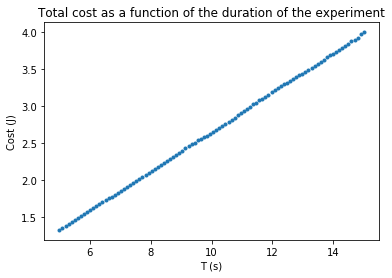

In [11]:
plt.plot(tarray,cost,'.')
plt.title('Total cost as a function of the duration of the experiment')
plt.ylabel('Cost (J)')
plt.xlabel('T (s)')
plt.show()

The following code creates a reward function. The amplitude still needs to be determined.

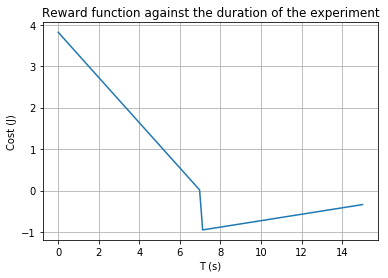

In [14]:
def reward(T):
    time=np.linspace(0,15,100)
    reward=np.zeros(100)
    for i in range(len(reward)):
        if time[i]<7.0:
            reward[i]=-3/5.5*(time[i]-7.0)
        elif time[i]>=7.0:
            reward[i]=0.0775*time[i]-1.5
    return(reward)
    
plt.plot(np.linspace(0,15,100),reward(15))
plt.title('Reward function against the duration of the experiment')
plt.xlabel('T (s)')
plt.ylabel('Cost (J)')
plt.grid()
plt.show()

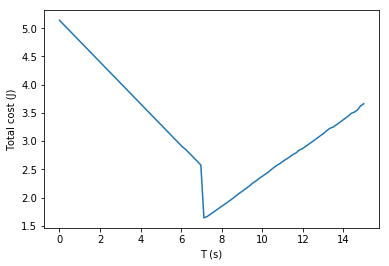

In [17]:
cost=[4.0*c/np.max(cost) for c in cost] #change amplitude to see something
totalcost=[sum(x) for x in zip(cost, reward(15))] #with quadratic cost of time
plt.plot(np.linspace(0,15,100),totalcost) 
plt.xlabel('T (s)')
plt.ylabel('Total cost (J)')
plt.show()

> Eventually, we can implement a cost of time, that should allow us to recover precisely the entrance time (the duration) that the rats favor. If we imagine a quadratic cost of time, we get the following total cost:

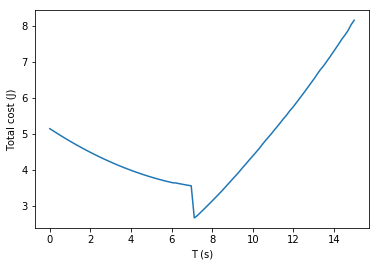

In [18]:
totalcost=[sum(x) for x in zip(cost, reward(15),[0.02*T**2 for T in np.linspace(0,15,100)])] #with quadratic cost of time
plt.plot(np.linspace(0,15,100),totalcost) 
plt.xlabel('T (s)')
plt.ylabel('Total cost (J)')
plt.show()


> The CoT must be changed until we find the right minimum. Better: we could subtract the total cost without CoT to an experimentally computed total cost (by plugging the actual trajectories in Keller's model for example...). 